In [1]:
# import here
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

---
# Load The Data

In [2]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


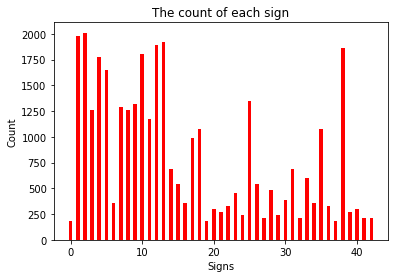

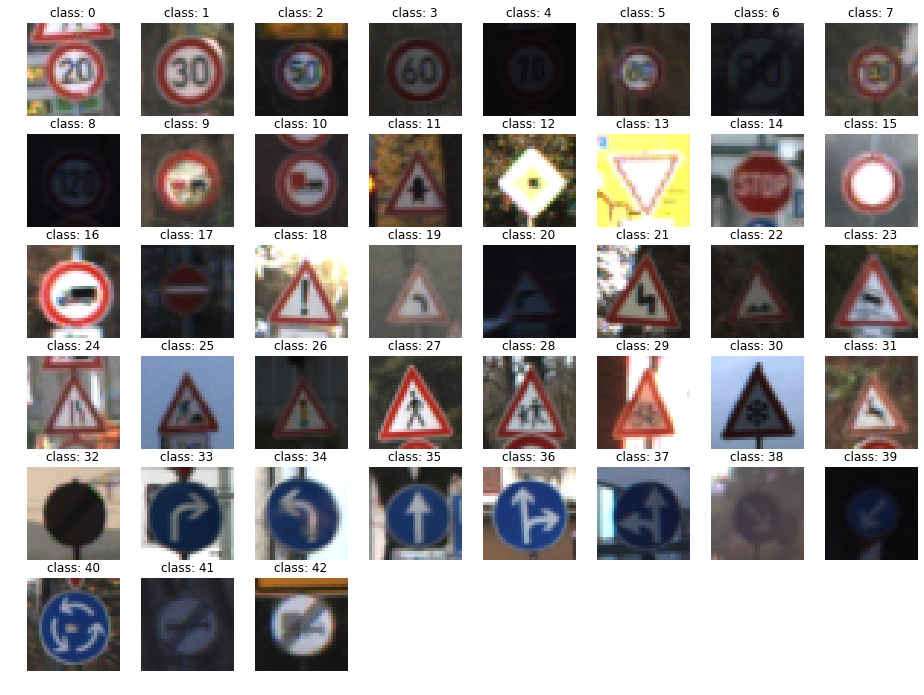

In [4]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [5]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [6]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [7]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [8]:
torch.manual_seed(1)

In [9]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, preprocess)
valid_loader = WrappedDataLoader(valid_loader, preprocess)
test_loader = WrappedDataLoader(test_loader, preprocess)

In [11]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [12]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [13]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [14]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")

In [15]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [16]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.675411	Validation loss: 3.591667	 Validation accruacy: 5.624%
[Epoch 2/20] Train loss: 3.484737	Validation loss: 3.570444	 Validation accruacy: 6.122%
[Epoch 3/20] Train loss: 3.457506	Validation loss: 3.540013	 Validation accruacy: 7.052%
[Epoch 4/20] Train loss: 3.340073	Validation loss: 3.348057	 Validation accruacy: 17.143%
[Epoch 5/20] Train loss: 2.710936	Validation loss: 2.370188	 Validation accruacy: 37.778%
[Epoch 6/20] Train loss: 1.719617	Validation loss: 1.631228	 Validation accruacy: 53.356%
[Epoch 7/20] Train loss: 1.146605	Validation loss: 1.171348	 Validation accruacy: 66.780%
[Epoch 8/20] Train loss: 0.856791	Validation loss: 0.972196	 Validation accruacy: 72.857%
[Epoch 9/20] Train loss: 0.679636	Validation loss: 0.964287	 Validation accruacy: 72.449%
[Epoch 10/20] Train loss: 0.564750	Validation loss: 0.821155	 Validation accruacy: 77.324%
[Epoch 11/20] Train loss: 0.476922	Validation loss: 0.721985	 Validation accruacy: 80.113%
[Epoch 12/2

---
# Experiment and find tuning

## Data preprocessing

In [17]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

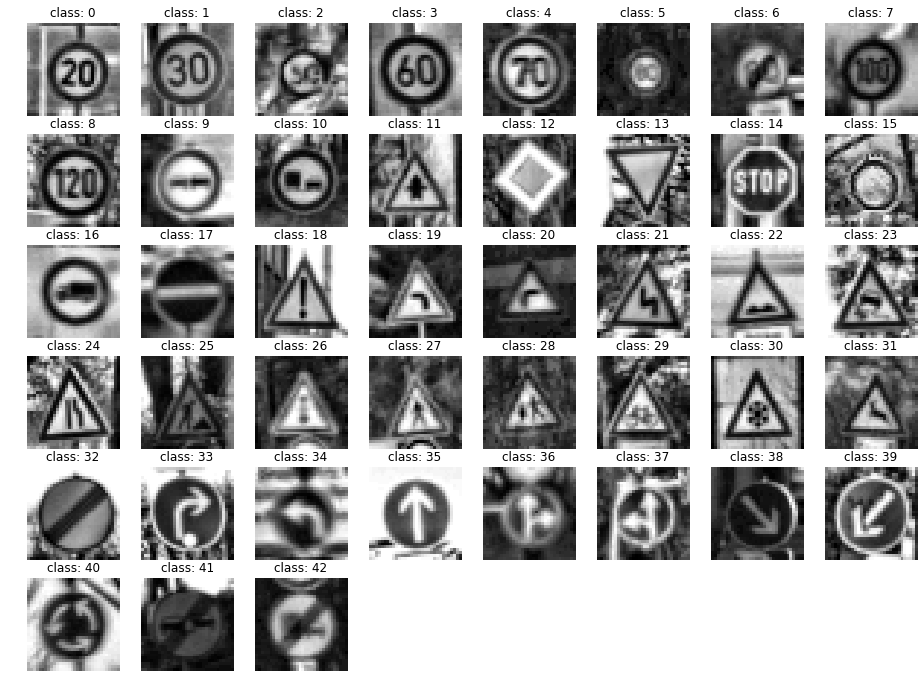

In [18]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [19]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [20]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.727780	Validation loss: 3.685289	 Validation accruacy: 5.442%
[Epoch 2/20] Train loss: 3.526138	Validation loss: 3.555121	 Validation accruacy: 5.442%
[Epoch 3/20] Train loss: 3.442491	Validation loss: 3.492977	 Validation accruacy: 14.558%
[Epoch 4/20] Train loss: 3.126839	Validation loss: 2.770002	 Validation accruacy: 28.322%
[Epoch 5/20] Train loss: 1.984049	Validation loss: 1.630639	 Validation accruacy: 54.376%
[Epoch 6/20] Train loss: 1.199992	Validation loss: 1.086490	 Validation accruacy: 68.413%
[Epoch 7/20] Train loss: 0.837822	Validation loss: 0.815031	 Validation accruacy: 74.717%
[Epoch 8/20] Train loss: 0.647920	Validation loss: 0.700110	 Validation accruacy: 79.161%
[Epoch 9/20] Train loss: 0.530488	Validation loss: 0.642968	 Validation accruacy: 79.365%
[Epoch 10/20] Train loss: 0.442623	Validation loss: 0.584023	 Validation accruacy: 82.268%
[Epoch 11/20] Train loss: 0.382046	Validation loss: 0.493410	 Validation accruacy: 85.102%
[Epoch 12/

## Handling imbalanced dataset

### Flipping

In [21]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [22]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)

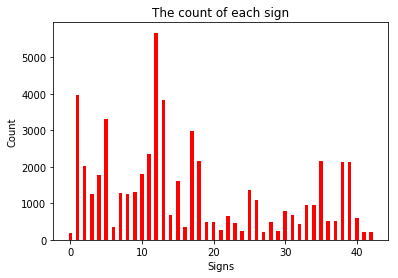

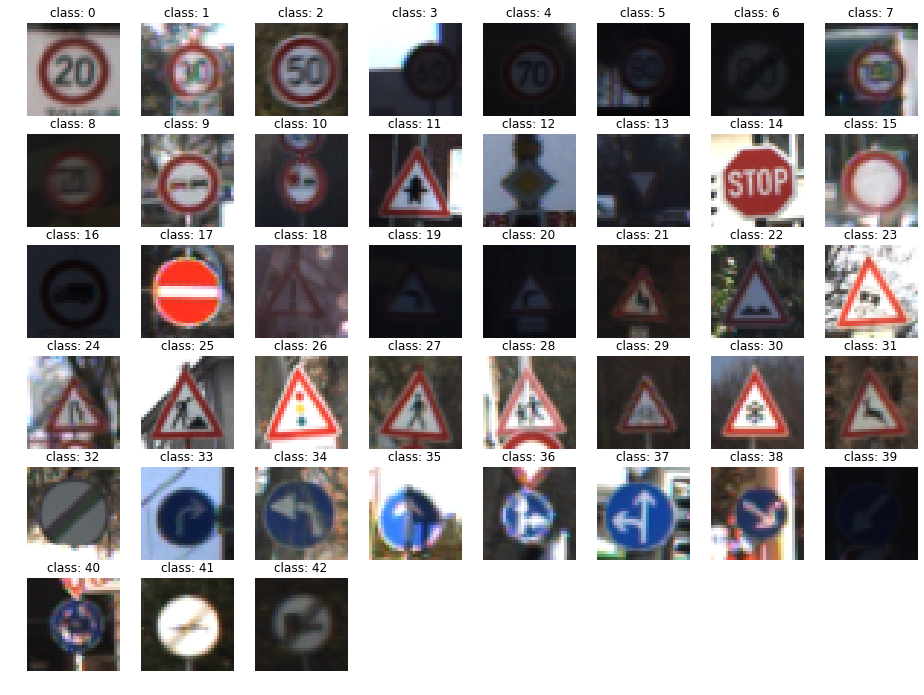

In [23]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i])

In [24]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.606555	Validation loss: 3.639100	 Validation accruacy: 4.762%
[Epoch 2/20] Train loss: 3.379745	Validation loss: 3.599585	 Validation accruacy: 6.735%
[Epoch 3/20] Train loss: 2.687270	Validation loss: 2.179849	 Validation accruacy: 36.667%
[Epoch 4/20] Train loss: 1.290966	Validation loss: 1.273723	 Validation accruacy: 61.474%
[Epoch 5/20] Train loss: 0.829774	Validation loss: 0.958962	 Validation accruacy: 71.519%
[Epoch 6/20] Train loss: 0.623306	Validation loss: 0.739428	 Validation accruacy: 78.503%
[Epoch 7/20] Train loss: 0.489767	Validation loss: 0.618507	 Validation accruacy: 82.676%
[Epoch 8/20] Train loss: 0.400953	Validation loss: 0.610489	 Validation accruacy: 82.041%
[Epoch 9/20] Train loss: 0.334988	Validation loss: 0.520270	 Validation accruacy: 84.762%
[Epoch 10/20] Train loss: 0.285498	Validation loss: 0.484861	 Validation accruacy: 85.420%
[Epoch 11/20] Train loss: 0.248553	Validation loss: 0.473384	 Validation accruacy: 86.236%
[Epoch 12/

### Augmentation

In [25]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 20000)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), preprocess)

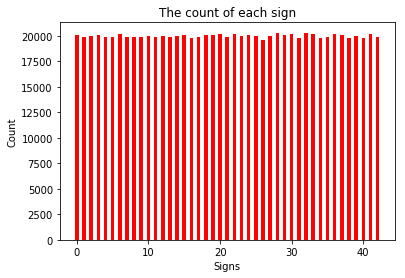

In [26]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [27]:
train_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [28]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

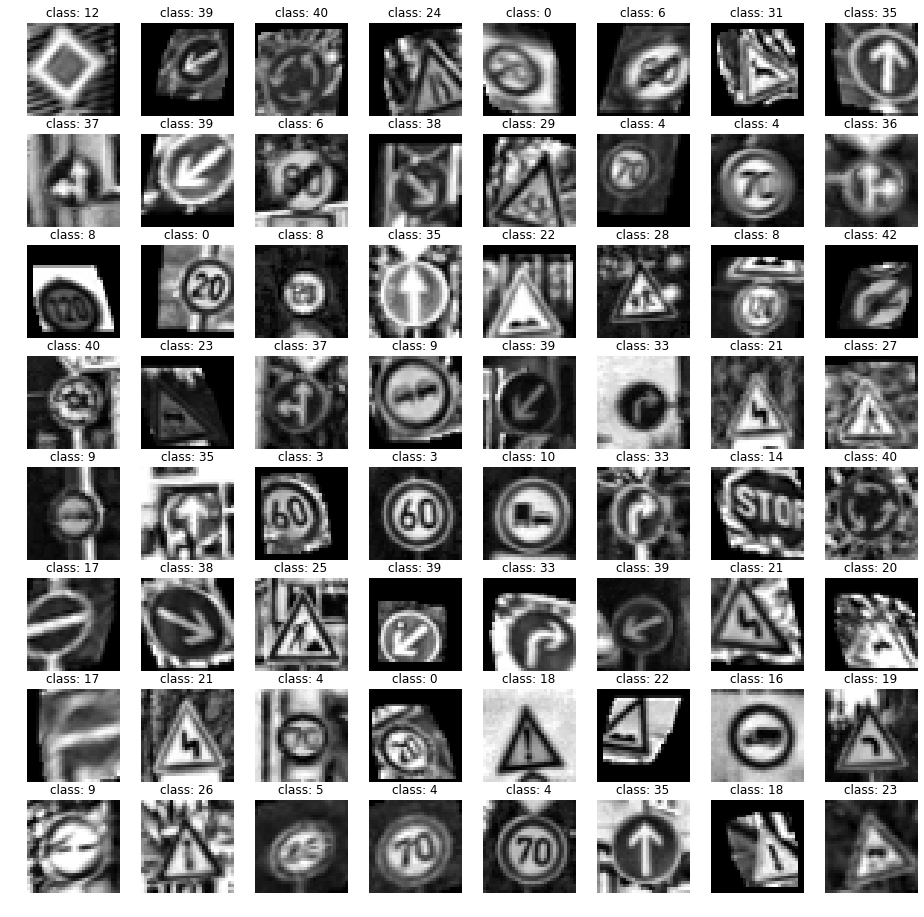

In [29]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [30]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 2.388674	Validation loss: 0.613805	 Validation accruacy: 81.270%
[Epoch 2/20] Train loss: 0.768241	Validation loss: 0.373562	 Validation accruacy: 89.773%
[Epoch 3/20] Train loss: 0.505688	Validation loss: 0.329335	 Validation accruacy: 91.859%
[Epoch 4/20] Train loss: 0.403810	Validation loss: 0.316597	 Validation accruacy: 91.973%
[Epoch 5/20] Train loss: 0.345442	Validation loss: 0.271272	 Validation accruacy: 93.719%
[Epoch 6/20] Train loss: 0.304076	Validation loss: 0.274285	 Validation accruacy: 93.946%
[Epoch 7/20] Train loss: 0.273624	Validation loss: 0.240078	 Validation accruacy: 94.127%
[Epoch 8/20] Train loss: 0.248375	Validation loss: 0.217120	 Validation accruacy: 94.558%
[Epoch 9/20] Train loss: 0.229423	Validation loss: 0.245659	 Validation accruacy: 94.535%
[Epoch 10/20] Train loss: 0.214765	Validation loss: 0.254394	 Validation accruacy: 93.855%
[Epoch 11/20] Train loss: 0.202018	Validation loss: 0.208282	 Validation accruacy: 95.601%
[Epoch 1

## Model

In [31]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 100)
        self.dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, 43)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = self.fc1_bn(F.elu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

In [36]:
n_epochs = 100
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/100] Train loss: 1.202891	Validation loss: 0.133429	 Validation accruacy: 96.372%
Validation loss decreased (inf --> 0.133429). Saving model...
[Epoch 2/100] Train loss: 0.478449	Validation loss: 0.075222	 Validation accruacy: 97.324%
Validation loss decreased (0.133429 --> 0.075222). Saving model...
[Epoch 3/100] Train loss: 0.343890	Validation loss: 0.085887	 Validation accruacy: 97.868%
[Epoch 4/100] Train loss: 0.279696	Validation loss: 0.070545	 Validation accruacy: 98.163%
Validation loss decreased (0.075222 --> 0.070545). Saving model...
[Epoch 5/100] Train loss: 0.238400	Validation loss: 0.083026	 Validation accruacy: 98.231%
[Epoch 6/100] Train loss: 0.213335	Validation loss: 0.084705	 Validation accruacy: 98.481%
[Epoch 7/100] Train loss: 0.193178	Validation loss: 0.091869	 Validation accruacy: 98.458%
[Epoch 8/100] Train loss: 0.177805	Validation loss: 0.072277	 Validation accruacy: 98.617%
[Epoch 9/100] Train loss: 0.165308	Validation loss: 0.090108	 Validation acc

In [37]:
check_point = torch.load('model.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.073651	Test accruacy: 97.696%


# Spatial transformer networks

In [38]:
class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.LeakyReLU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.LeakyReLU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

In [39]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.stn = Stn()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 100)
        self.dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, 43)

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = self.fc1_bn(F.elu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        x = self.fc3(x)
        return x

In [40]:
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/100] Train loss: 0.586886	Validation loss: 0.089241	 Validation accruacy: 98.163%
Validation loss decreased (inf --> 0.089241). Saving model...
[Epoch 2/100] Train loss: 0.073365	Validation loss: 0.087237	 Validation accruacy: 98.390%
Validation loss decreased (0.089241 --> 0.087237). Saving model...
[Epoch 3/100] Train loss: 0.038468	Validation loss: 0.086549	 Validation accruacy: 98.549%
Validation loss decreased (0.087237 --> 0.086549). Saving model...
[Epoch 4/100] Train loss: 0.026840	Validation loss: 0.058188	 Validation accruacy: 98.753%
Validation loss decreased (0.086549 --> 0.058188). Saving model...
[Epoch 5/100] Train loss: 0.020797	Validation loss: 0.067387	 Validation accruacy: 98.798%
[Epoch 6/100] Train loss: 0.018069	Validation loss: 0.066305	 Validation accruacy: 98.571%
[Epoch 7/100] Train loss: 0.015630	Validation loss: 0.054537	 Validation accruacy: 98.957%
Validation loss decreased (0.058188 --> 0.054537). Saving model...
[Epoch 8/100] Train loss: 0.01363

In [41]:
check_point = torch.load('model.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.030610	Test accruacy: 99.232%


## Visualizing the STN results

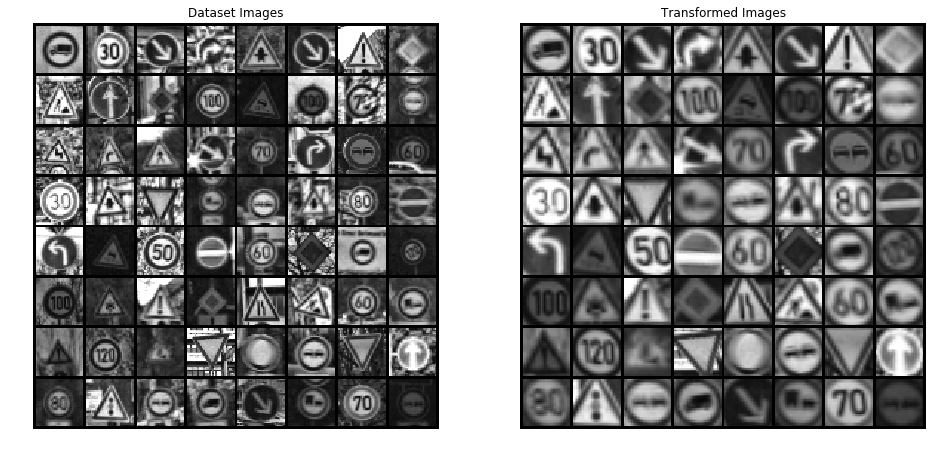

In [42]:
def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
visualize_stn()